## Import TensorFlow and other libraries

In [1]:
import outils
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = outils.Load_data.load_object("dataset2.zip")

In [4]:
input_shape = (64,64,3)

In [5]:
df.reshape(target_shape=input_shape, batch_size = 32)

Reshape en batch: 100%|██████████| 380/380 [00:24<00:00, 15.48it/s]


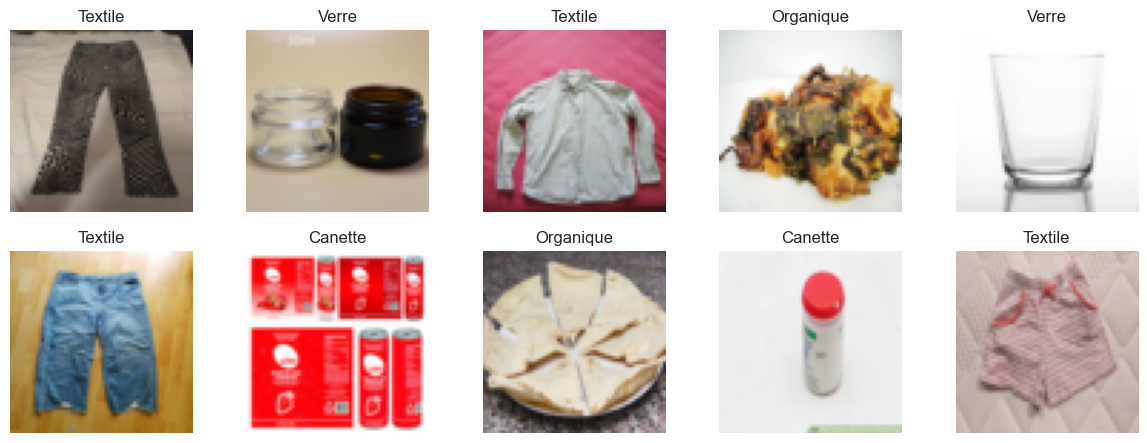

In [6]:
df.plot()

In [7]:
df.encodage()

In [30]:
(X_train, _), (X_test, _ ) = df.create_data(test_size=0.1)

In [31]:
print(f"X_train shape : {X_train.shape}")
print(f"X_test  shape : {X_test.shape}")

X_train shape : (10924, 64, 64, 3)
X_test  shape : (1214, 64, 64, 3)


In [32]:
X_vis = X_test[0:10]

In [33]:
X_vis = X_vis.astype("float32") / 255.

In [34]:
train_datagen = ImageDataGenerator(
    rotation_range=35,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest',
    rescale=1./255
)
test_datagen =  ImageDataGenerator(rescale= 1. / 255)

In [35]:
train_generator = train_datagen.flow(X_train,X_train,batch_size=32)
test_generator  = test_datagen.flow(X_test,X_test,batch_size=32)

In [ ]:
#noisy_gaussian = noise_adder.apply("gaussian", std=0.2)

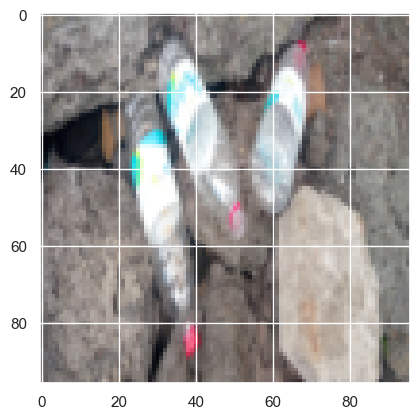

In [15]:
plt.imshow(X_test[8])

In [14]:
print(f"min = {np.min(X_test)} et max = {np.max(X_test)}")

min = 0 et max = 255


In [13]:
print(f"min = {np.min(X_train)} et max = {np.max(X_train)}")

min = 0.0 et max = 1.0


In [ ]:
plt.figure(figsize=(18,9))
for i in range(1,11):
    plt.subplot(4,5,i)
    plt.imshow(X_train[i])
    plt.title(y_train[i])
    plt.tight_layout()
plt.show()

In [15]:
import os 
import json
import tensorflow as tf 
from tensorflow.keras import layers, models, losses, callbacks, regularizers
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau

In [16]:
from keras.saving import register_keras_serializable

In [ ]:
def ResidualBlock(filters, stride=1, use_bn=True, l2=1e-4):
    def f(x):
        shortcut = x
        y = layers.Conv2D(filters, 3, strides=stride, padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(l2), use_bias=not use_bn)(x)
        if use_bn: y = layers.BatchNormalization()(y)
        y = layers.Activation("relu")(y)

        y = layers.Conv2D(filters, 3, padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(l2), use_bias=not use_bn)(y)
        if use_bn: y = layers.BatchNormalization()(y)

        # Adapter raccourci
        if shortcut.shape[-1] != filters or stride != 1:
            shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same",
                                     kernel_regularizer=tf.keras.regularizers.l2(l2),
                                     use_bias=not use_bn)(shortcut)
            if use_bn: shortcut = layers.BatchNormalization()(shortcut)

        out = layers.Add()([y, shortcut])
        out = layers.Activation("relu")(out)
        return out
    return f


# -----------------------------
# Bloc résiduel upsampling
# -----------------------------
def ResidualBlockUp(filters, scale=2, use_bn=True, l2=1e-4):
    def f(x):
        shortcut = x
        y = layers.UpSampling2D(size=(scale, scale))(x)
        y = layers.Conv2D(filters, 3, padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(l2), use_bias=not use_bn)(y)
        if use_bn: y = layers.BatchNormalization()(y)
        y = layers.Activation("relu")(y)

        y = layers.Conv2D(filters, 3, padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(l2), use_bias=not use_bn)(y)
        if use_bn: y = layers.BatchNormalization()(y)

        shortcut = layers.UpSampling2D(size=(scale, scale))(shortcut)
        shortcut = layers.Conv2D(filters, 1, padding="same",
                                 kernel_regularizer=tf.keras.regularizers.l2(l2),
                                 use_bias=not use_bn)(shortcut)
        if use_bn: shortcut = layers.BatchNormalization()(shortcut)

        out = layers.Add()([y, shortcut])
        out = layers.Activation("relu")(out)
        return out
    return f


# -----------------------------
# Échantillonnage
# -----------------------------
@register_keras_serializable()
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_logvar = inputs
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_logvar) * eps


# -----------------------------
def build_encoder(input_shape=(240, 240, 3), latent_dim=128, base=32):
    inp = layers.Input(shape=input_shape)
    x = inp

    # downsampling avec blocs résiduels
    x = layers.Conv2D(base, 3, padding="same")(x)
    x = layers.Activation("relu")(x)

    x = ResidualBlock(base,   stride=1)(x)  # HxW
    x = ResidualBlock(base*2, stride=2)(x)  # H/2 x W/2
    x = ResidualBlock(base*2, stride=1)(x)
    x = ResidualBlock(base*4, stride=2)(x)  # H/4 x W/4
    x = ResidualBlock(base*4, stride=1)(x)
    x = ResidualBlock(base*8, stride=2)(x)  # H/8 x W/8
    x = ResidualBlock(base*8, stride=1)(x)

    x = layers.Conv2D(latent_dim, 1, padding="same")(x)
    x = layers.GlobalAveragePooling2D()(x)

    z_mean   = layers.Dense(latent_dim, name="z_mean")(x)
    z_logvar = layers.Dense(latent_dim, name="z_logvar")(x)
    z = Sampling()([z_mean, z_logvar])

    return tf.keras.Model(inp, [z_mean, z_logvar, z], name="encoder")

def build_decoder(output_shape=(240, 240, 3), latent_dim=128, base=32):
    H, W, C = output_shape
    # Taille de départ (doit être un diviseur de H,W après 3 downsamples → H/8,W/8)
    h0, w0 = H // 8, W // 8
    inp = layers.Input(shape=(latent_dim,))
    x = layers.Dense(h0 * w0 * base*8, activation="relu")(inp)
    x = layers.Reshape((h0, w0, base*8))(x)

    x = ResidualBlock(base*8, stride=1)(x)
    x = ResidualBlockUp(base*4)(x)  # H/4
    x = ResidualBlock(base*4, stride=1)(x)
    x = ResidualBlockUp(base*2)(x)  # H/2
    x = ResidualBlock(base*2, stride=1)(x)
    x = ResidualBlockUp(base)(x)    # H
    x = ResidualBlock(base, stride=1)(x)

    # Sortie dans [0,1] via sigmoid
    out = layers.Conv2D(C, 3, padding="same", activation="sigmoid")(x)
    return tf.keras.Model(inp, out, name="decoder")


# -----------------------------
# Callback pour affichage reconstruction
# -----------------------------
class PlotReconstructionCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, x_vis):
        super().__init__()
        self.vae_model = model
        self.x_vis = x_vis#.astype("float32") / 255.0  # normalisation ici

    def on_epoch_end(self, epoch, logs=None):
        z_mean, z_logvar, z = self.vae_model.encoder.predict(self.x_vis)
        recon = self.vae_model.decoder.predict(z)
        n = min(5, len(self.x_vis))
        plt.figure(figsize=(20, 8))
        for i in range(n):
            plt.subplot(2, n, i + 1)
            plt.imshow(np.clip(self.x_vis[i], 0, 1))
            plt.axis("off")
            plt.title("Original")

            plt.subplot(2, n, n + i + 1)
            plt.imshow(np.clip(recon[i], 0, 1))
            plt.axis("off")
            plt.title("Reconstruit")
        plt.suptitle(f"Époque {epoch + 1}")
        plt.tight_layout()
        plt.show()



class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, save_dir="training_checkpoint"):
        super().__init__()
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Mettre à jour l'historique
        for k, v in logs.items():
            self.history.setdefault(k, []).append(float(v))

        # Sauvegarde de l’historique JSON
        history_path = os.path.join(self.save_dir, "history.json")
        with open(history_path, "w") as f:
            json.dump(self.history, f)

        # Sauvegarde de l'époque actuelle
        epoch_path = os.path.join(self.save_dir, "epoch.txt")
        with open(epoch_path, "w") as f:
            f.write(str(epoch + 1))  # +1 car epoch commence à 0

        
@register_keras_serializable()
class ResidualVAE(tf.keras.Model):
    def __init__(
        self, 
        encoder, 
        decoder, 
        beta=0.001,
        add_noise=True,          # <-- activer/désactiver le bruit
        noise_std=0.2,           # <-- intensité du bruit gaussien
        dropout_rate=0.0,        # <-- dropout aléatoire optionnel
        **kwargs
    ):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

        self.add_noise = add_noise
        self.noise_std = noise_std
        self.dropout_rate = dropout_rate

        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")


    # Pour la sérialisation Keras
    def get_config(self):
        config = super().get_config()
        config.update({
            "beta": self.beta,
            "add_noise": self.add_noise,
            "noise_std": self.noise_std,
            "dropout_rate": self.dropout_rate,
            "encoder": tf.keras.utils.serialize_keras_object(self.encoder),
            "decoder": tf.keras.utils.serialize_keras_object(self.decoder),
        })
        return config

    @classmethod
    def from_config(cls, config):
        encoder = tf.keras.utils.deserialize_keras_object(config.pop("encoder"))
        decoder = tf.keras.utils.deserialize_keras_object(config.pop("decoder"))
        return cls(encoder=encoder, decoder=decoder, **config)


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.recon_loss_tracker,
            self.kl_loss_tracker,
        ]


    # ------------------------
    # Fonction pour ajouter du bruit
    # ------------------------
    def add_training_noise(self, x):
        if not self.add_noise:
            return x

        # Bruit gaussien
        x_noisy = x + tf.random.normal(
            shape=tf.shape(x),
            mean=0.0,
            stddev=self.noise_std
        )

        # Dropout (optionnel)
        if self.dropout_rate > 0.0:
            x_noisy = tf.nn.dropout(x_noisy, rate=self.dropout_rate)

        # Clamp entre 0–1
        x_noisy = tf.clip_by_value(x_noisy, 0.0, 1.0)

        return x_noisy


    # ------------------------
    # TRAIN STEP MODIFIÉ
    # ------------------------
    def train_step(self, data):
        x = data[0] if isinstance(data, (tuple, list)) else data

        # Ajout du bruit ici 
        x_noisy = self.add_training_noise(x)

        with tf.GradientTape() as tape:
            z_mean, z_logvar, _ = self.encoder(x_noisy, training=True)
            z = z_mean   # PAS de sampling
            x_hat = self.decoder(z, training=True)

            # Reconstruction loss
            recon_loss = tf.reduce_mean(
            tf.reduce_sum(tf.square(x - x_hat), axis=(1, 2, 3))
            )
            #recon_loss = tf.reduce_mean(
            #    tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_hat), axis=(1, 2))
            #)

            # KL-divergence
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_mean(
                    1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar), axis=1
                )
            )

            total_loss = recon_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


    # ------------------------
    # TEST STEP (sans bruit)
    # ------------------------
    def test_step(self, data):
        x = data[0] if isinstance(data, (tuple, list)) else data

        # Pas de bruit en validation
        z_mean, z_logvar, z = self.encoder(x, training=False)
        x_hat = self.decoder(z, training=False)
        recon_loss = tf.reduce_mean(
            tf.reduce_sum(tf.square(x - x_hat), axis=(1, 2, 3))
        )
        #recon_loss = tf.reduce_mean(
        #   tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_hat), axis=(1, 2))
        #)

        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_mean(1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar), axis=1)
        )

        total_loss = recon_loss + self.beta * kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

   

                
    def train(
        self, x_train, x_val=None, batch_size=32,
        epochs=100, x_vis=None, save_path="residual_vae.keras", 
        save_dir="training_checkpoint", initial_epoch=0,
    ):
        self.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4, clipnorm=1.0))

        callbacks_list = [
            SaveHistoryCallback(save_dir=save_dir),
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=20, restore_best_weights=True
            ),
            tf.keras.callbacks.ModelCheckpoint(save_path,monitor="recon_loss",verbose=1,save_best_only=True,mode="min"),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss", factor=0.5, patience=5, verbose=1, min_lr=1e-7
            ),
        ]

        if x_vis is not None:
            callbacks_list.append(PlotReconstructionCallback(self, x_vis))

        history = self.fit(
            x_train,
            validation_data=x_val if x_val is not None else None,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks_list,
            shuffle=True,
            initial_epoch=initial_epoch,
        )
        return history

In [37]:
latent_dim  = 32

encoder = build_encoder(input_shape=input_shape , latent_dim=latent_dim, base=16)
decoder = build_decoder(output_shape=input_shape, latent_dim=latent_dim, base=16)

In [38]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 64, 64,    │        448 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 64, 64,    │          0 │ conv2d_37[0][0]   │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 64, 64,    │      2,304 │ activation_29[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │         64 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 64, 64,    │      2,304 │ activation_30[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │         64 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │ activation_29[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 64, 64,    │          0 │ add_14[0][0]      │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 32, 32,    │      4,608 │ activation_31[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 32, 32,    │      9,216 │ activation_32[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │        512 │ activation_31[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_42[0][0] 

 Total params: 704,032 (2.69 MB)

 Trainable params: 701,728 (2.68 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [39]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8192)      │    270,336 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 8, 8, 128) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 8, 8, 128) │    147,456 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_44       │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 8, 8, 128) │    147,456 │ activation_44[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│                     │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_45       │ (None, 8, 8, 128) │          0 │ add_21[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_6     │ (None, 16, 16,    │          0 │ activation_45[0]… │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 16, 16,    │     73,728 │ up_sampling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_58[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_46       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_7     │ (None, 16, 16,    │          0 │ activation_45[0]… │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 16, 16,    │     36,864 │ activation_46[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 16, 16,    │      8,192 │ up_sampling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_59[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                 

 Total params: 821,619 (3.13 MB)

 Trainable params: 819,987 (3.13 MB)

 Non-trainable params: 1,632 (6.38 KB)

In [40]:
import matplotlib.pyplot as plt

def plot_result(history, metrics=None, name_fig="fig", register=False):
    # Dictionnaire contenant toutes les métriques
    hist = history.history  

    # Si metrics n’est pas fourni, on prend toutes les clés
    if metrics is None:
        metrics = [m for m in hist.keys() if not m.startswith("val_")]

    n = len(metrics)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5))

    if n == 1:
        axes = [axes]  # uniformiser

    for i, metric in enumerate(metrics):
        ax = axes[i]
        ax.plot(hist[metric], label=f"Train {metric}")
        if f"val_{metric}" in hist:
            ax.plot(hist[f"val_{metric}"], label=f"Val {metric}")
        ax.set_title(metric.capitalize())
        ax.set_xlabel("Epochs")
        ax.set_ylabel(metric)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    if register:
        plt.savefig(f"{name_fig}.png")
    plt.show()

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model1 = load_model("model_dct_6.keras", custom_objects={"ResidualVAE": ResidualVAE, "Sampling": Sampling})

In [41]:
autoencoder = ResidualVAE(
    encoder,
    decoder,
    beta=0.00,
    add_noise=True,
    noise_std=0.02,   
    dropout_rate=0.02 
)


In [44]:
save_dir = "training_checkpoint"

# Charger historique
history_path = os.path.join(save_dir, "history.json")
if os.path.exists(history_path):
    with open(history_path, "r") as f:
        history_old = json.load(f)
else:
    history_old = {}

# Charger epoch
epoch_path = os.path.join(save_dir, "epoch.txt")
if os.path.exists(epoch_path):
    with open(epoch_path, "r") as f:
        start_epoch = int(f.read())
else:
    start_epoch = 0


Epoch 51/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - kl_loss: 4.6875 - loss: 2022.9409 - recon_loss: 2022.9409
Epoch 51: recon_loss improved from None to 2025.15820, saving model to model_dct_8.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


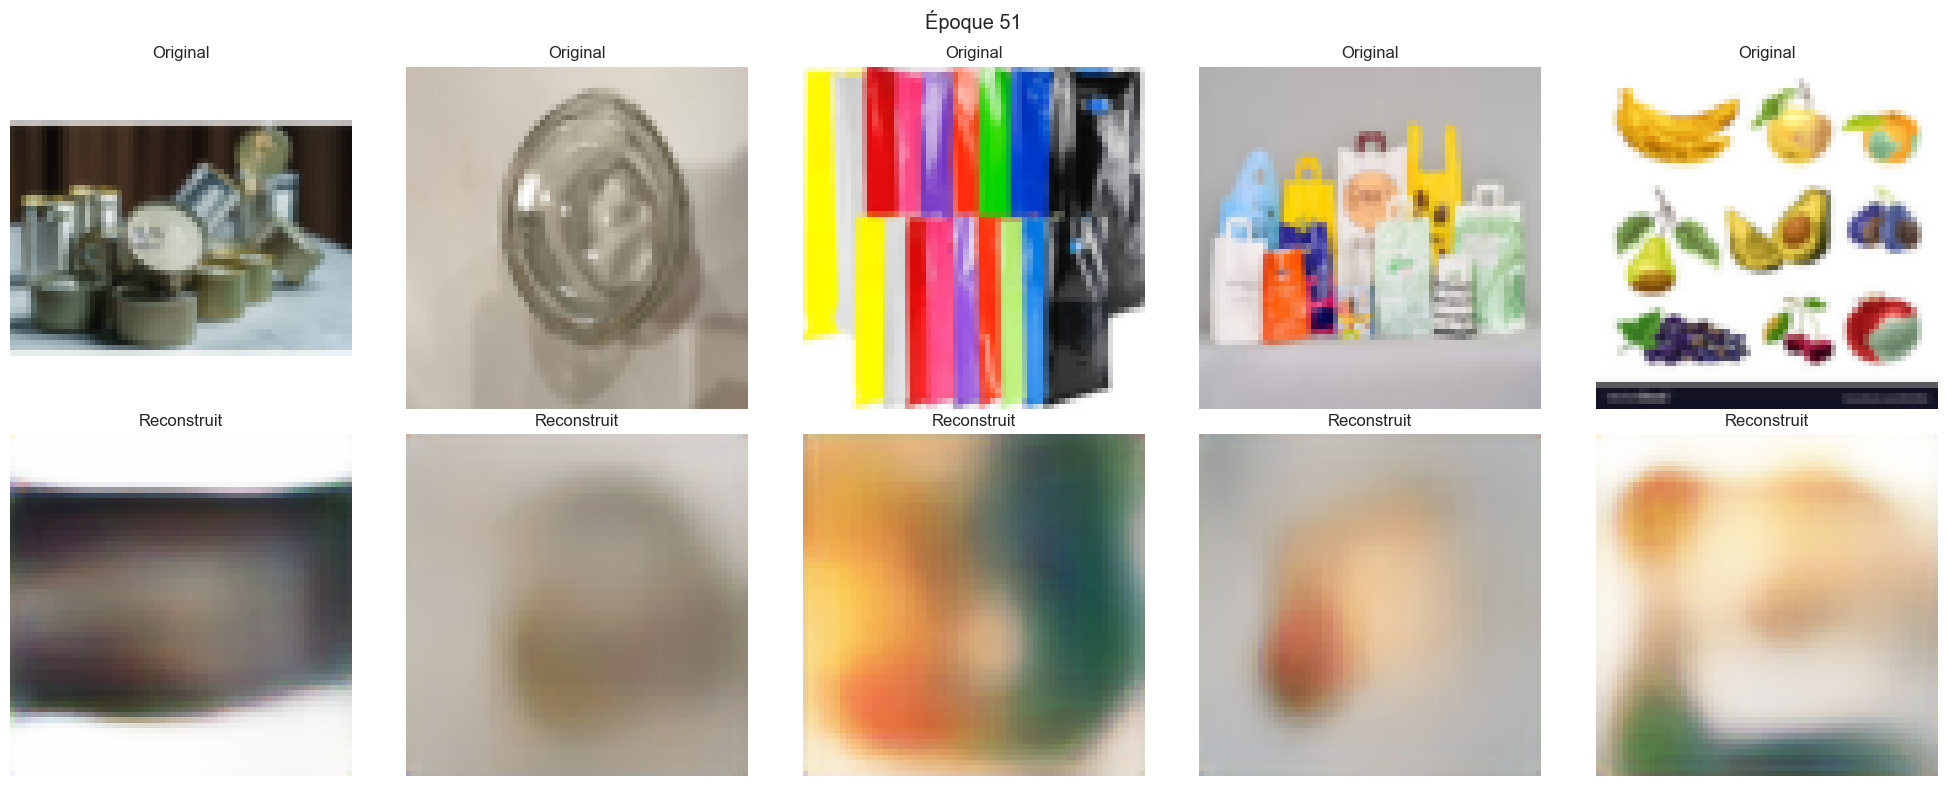

342/342 ━━━━━━━━━━━━━━━━━━━━ 310s 871ms/step - kl_loss: 4.6982 - loss: 2025.1582 - recon_loss: 2025.1582 - val_kl_loss: 5.6548 - val_loss: 2061.2205 - val_recon_loss: 2061.2205 - learning_rate: 1.0000e-04
Epoch 52/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 976ms/step - kl_loss: 4.7113 - loss: 2034.4393 - recon_loss: 2034.4393
Epoch 52: recon_loss did not improve from 2025.15820
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


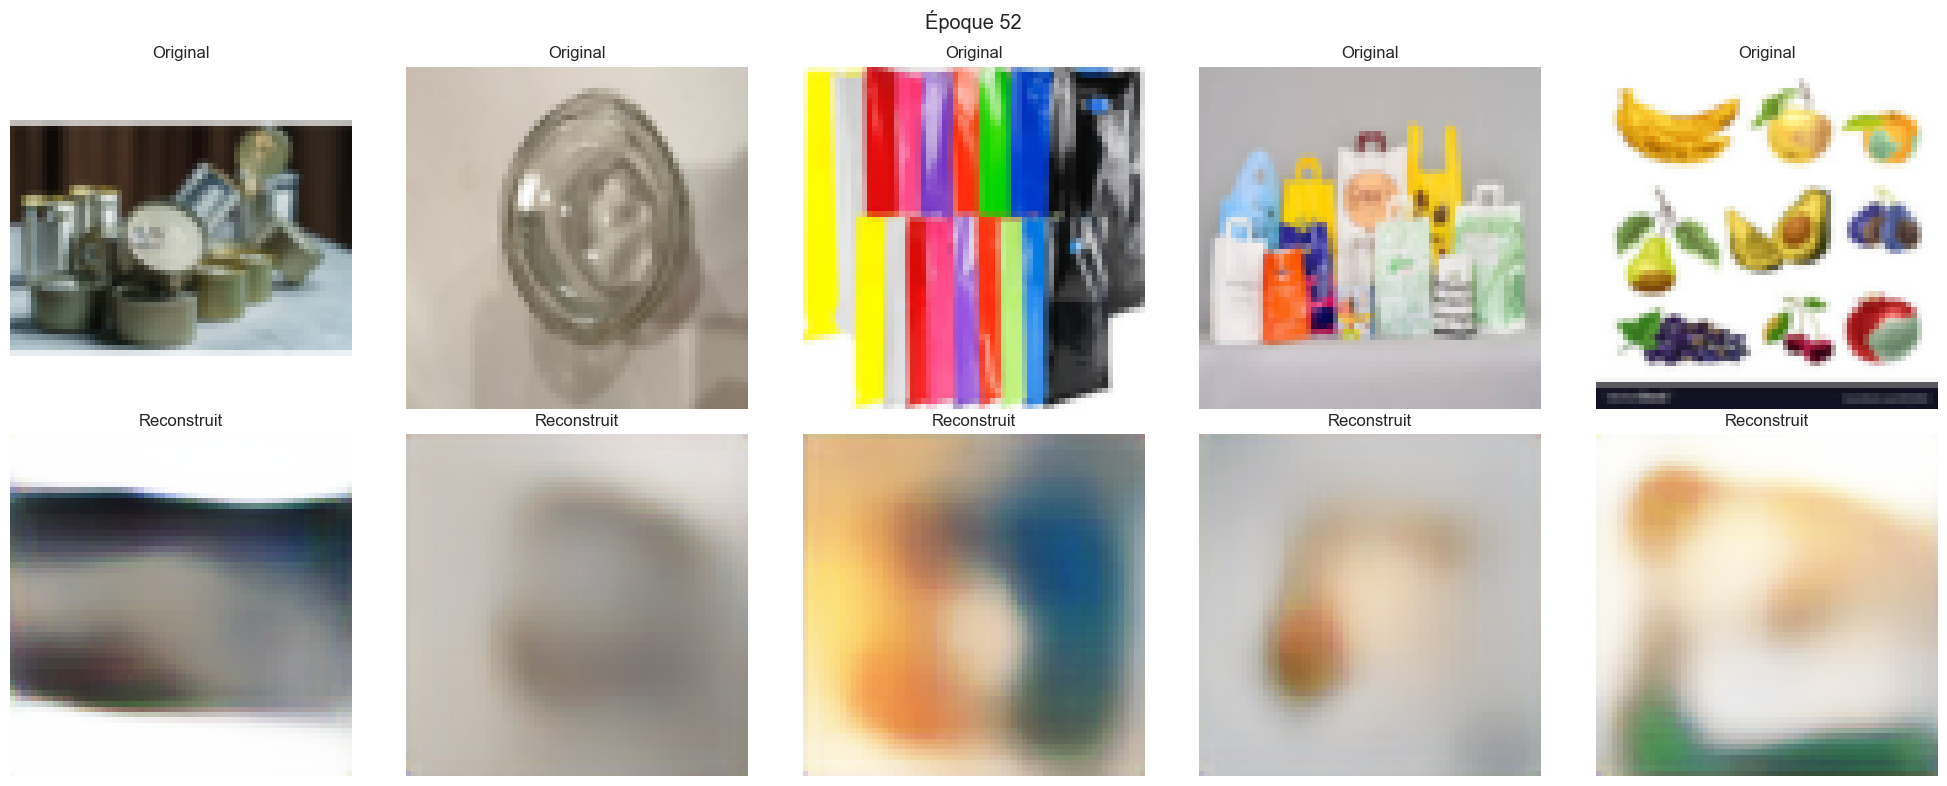

342/342 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - kl_loss: 4.7139 - loss: 2035.6893 - recon_loss: 2035.6893 - val_kl_loss: 5.9701 - val_loss: 2065.5703 - val_recon_loss: 2065.5703 - learning_rate: 1.0000e-04
Epoch 53/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - kl_loss: 4.7147 - loss: 2024.6370 - recon_loss: 2024.6370
Epoch 53: recon_loss did not improve from 2025.15820
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


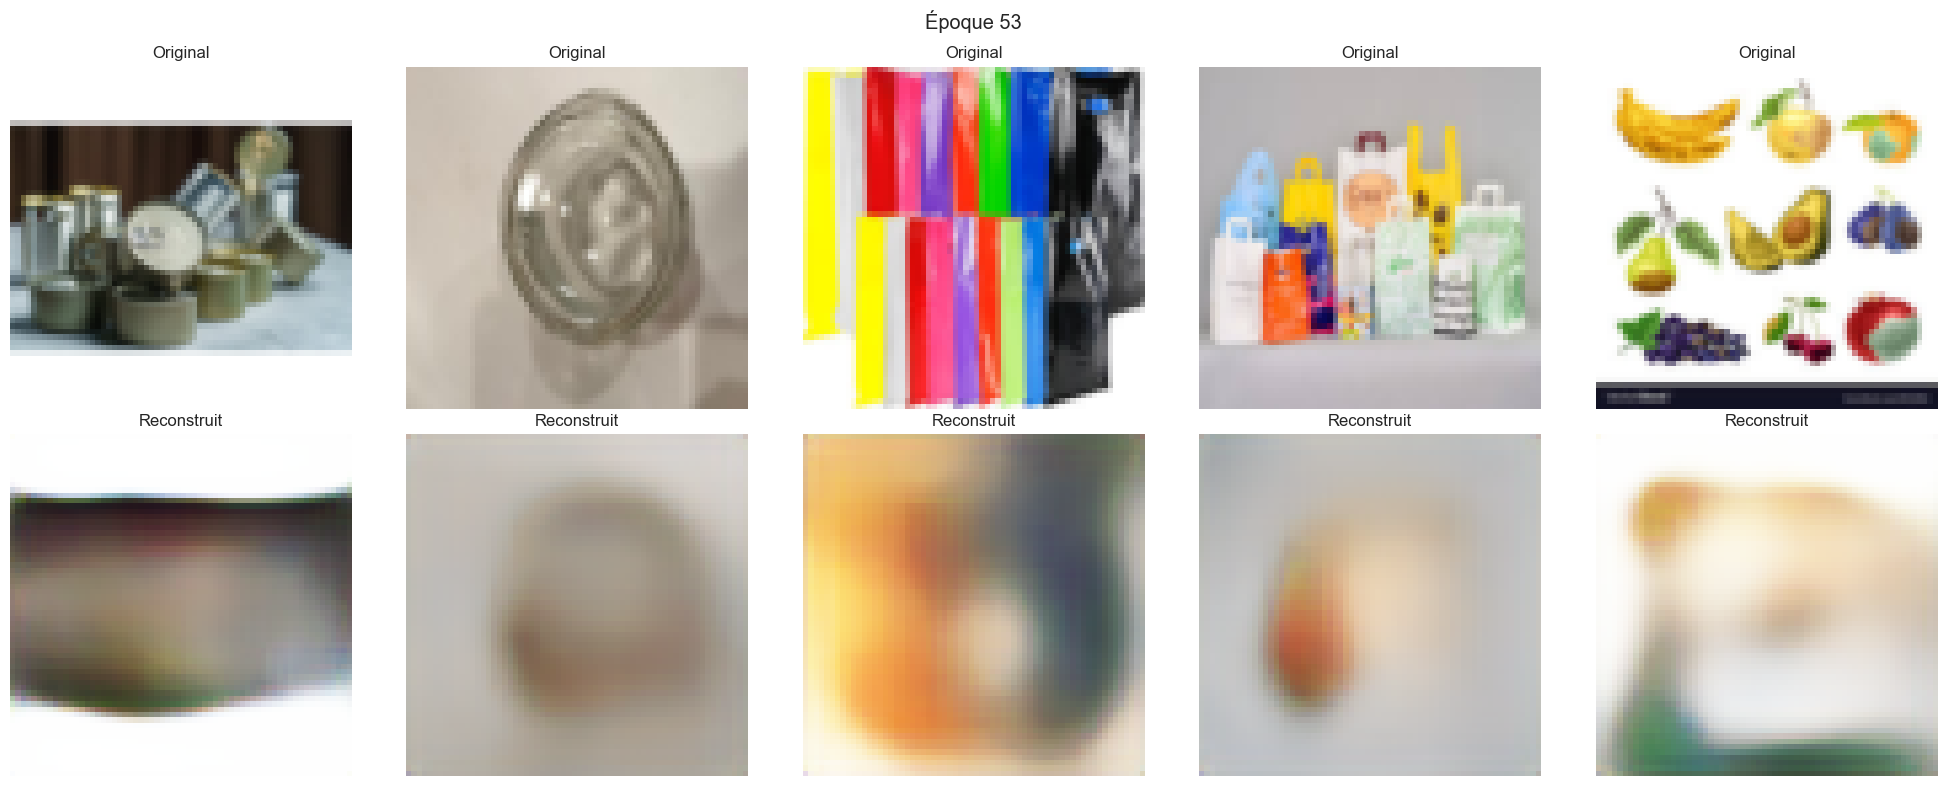

342/342 ━━━━━━━━━━━━━━━━━━━━ 348s 1s/step - kl_loss: 4.7158 - loss: 2026.8478 - recon_loss: 2026.8478 - val_kl_loss: 6.0148 - val_loss: 2084.2563 - val_recon_loss: 2084.2563 - learning_rate: 1.0000e-04
Epoch 54/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - kl_loss: 4.7190 - loss: 2025.8829 - recon_loss: 2025.8829
Epoch 54: recon_loss did not improve from 2025.15820
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


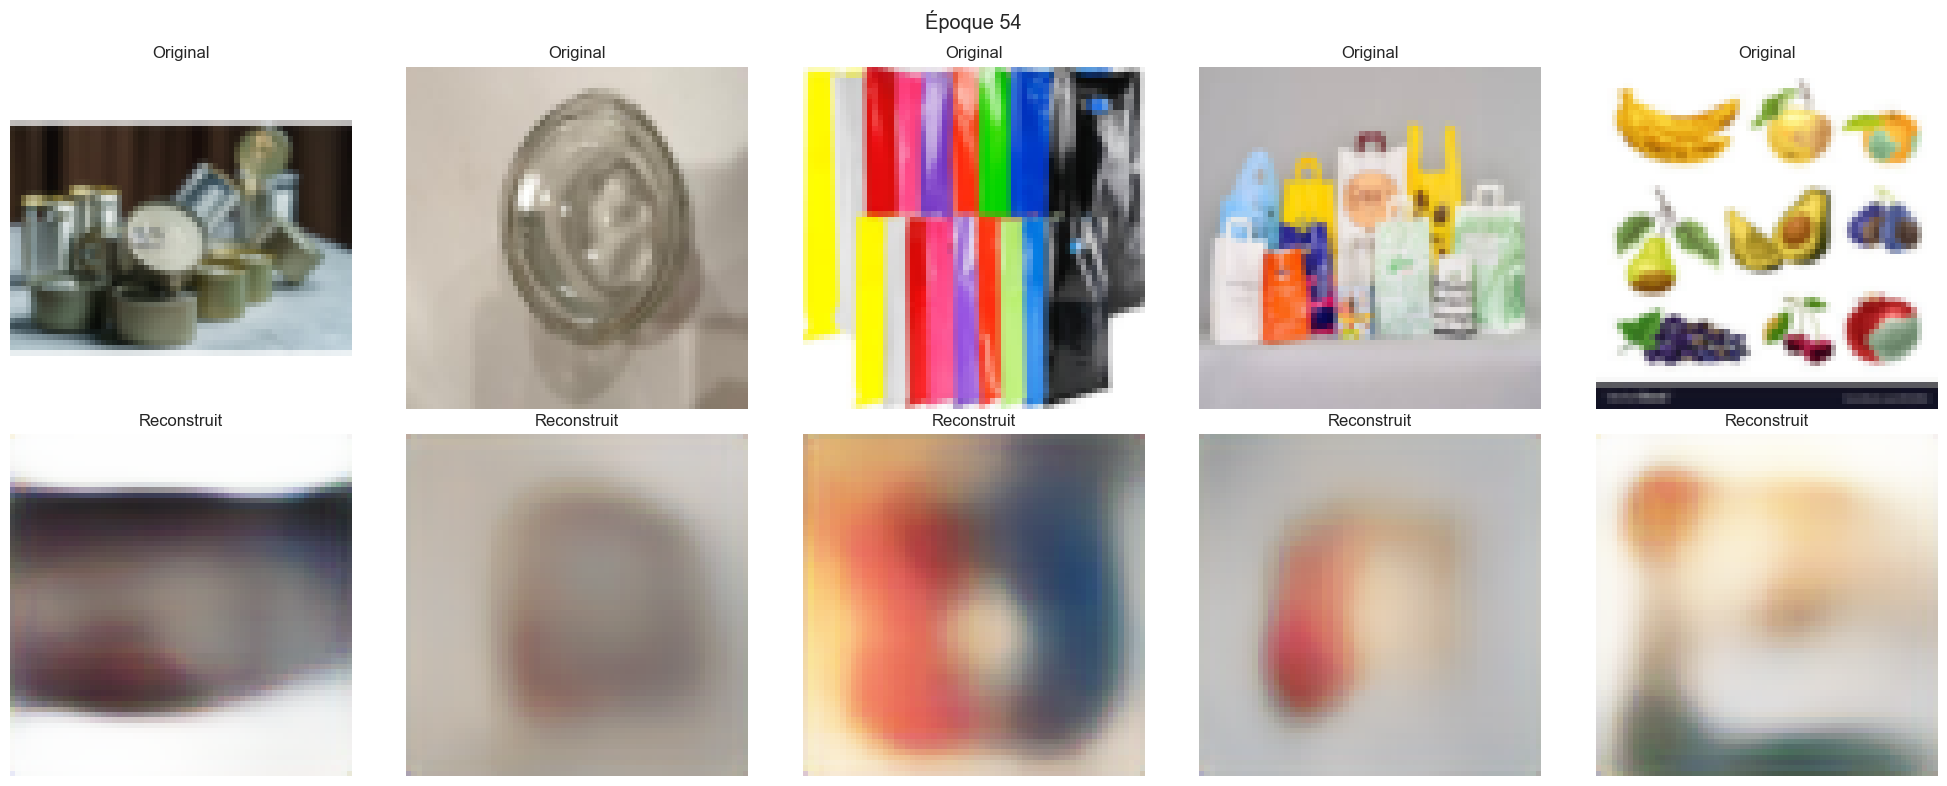

342/342 ━━━━━━━━━━━━━━━━━━━━ 351s 1s/step - kl_loss: 4.7182 - loss: 2037.6562 - recon_loss: 2037.6562 - val_kl_loss: 5.9099 - val_loss: 2047.6349 - val_recon_loss: 2047.6349 - learning_rate: 1.0000e-04
Epoch 55/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl_loss: 4.7166 - loss: 2030.0803 - recon_loss: 2030.0803
Epoch 55: recon_loss did not improve from 2025.15820
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


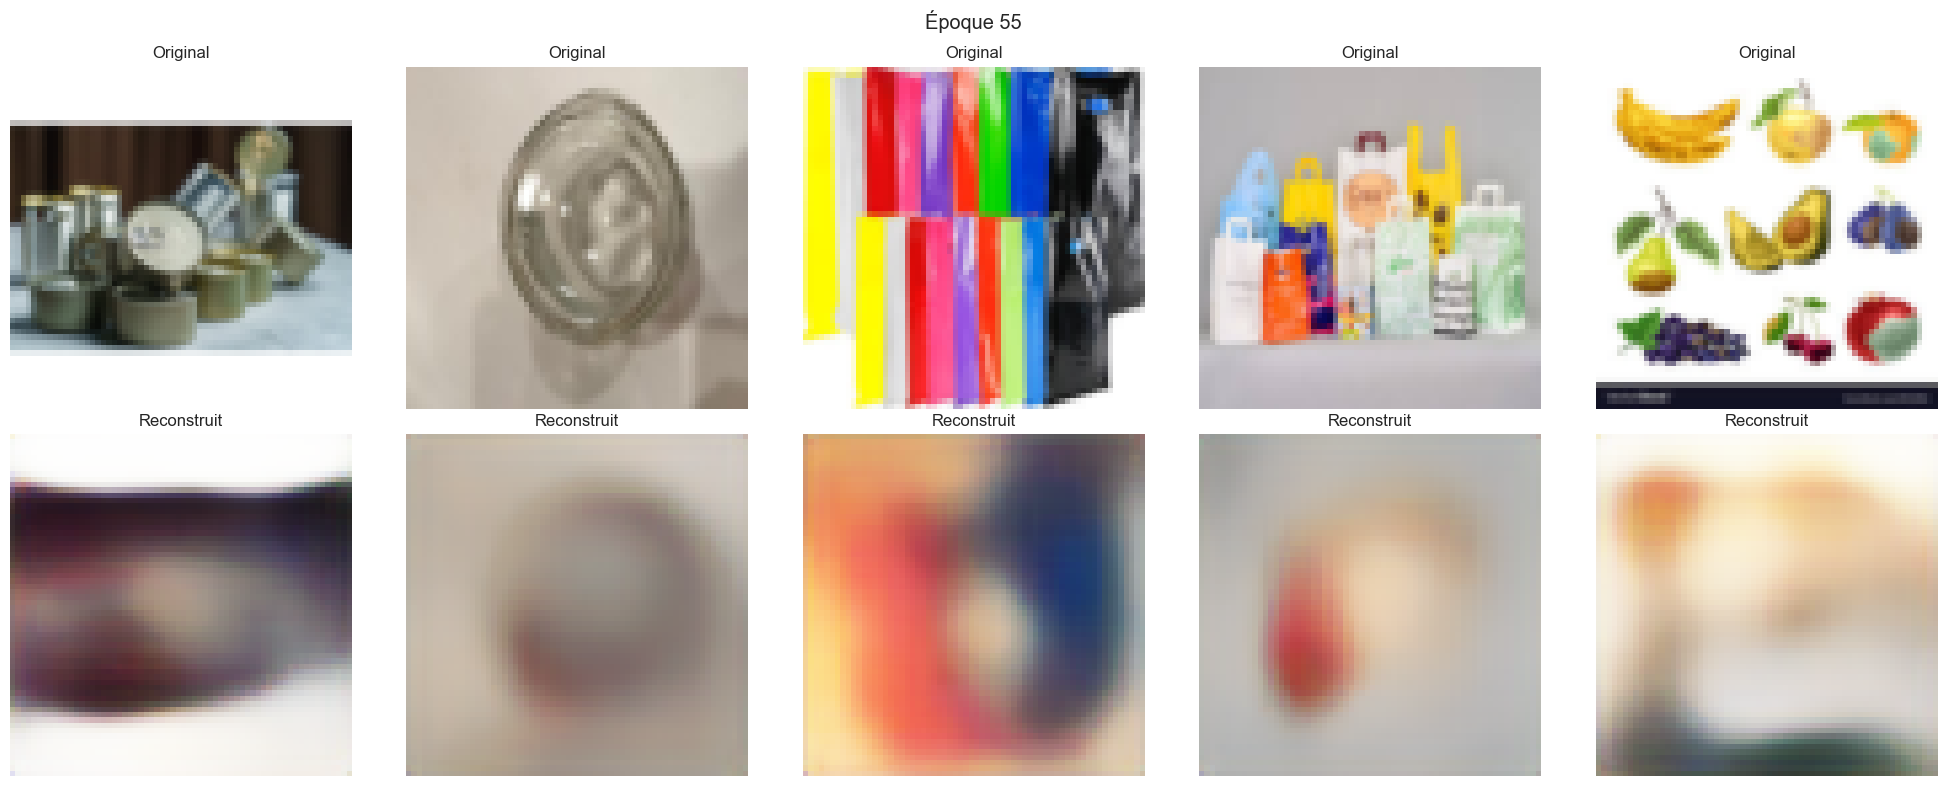

342/342 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - kl_loss: 4.7157 - loss: 2031.1946 - recon_loss: 2031.1946 - val_kl_loss: 5.9556 - val_loss: 2060.0889 - val_recon_loss: 2060.0889 - learning_rate: 1.0000e-04
Epoch 56/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl_loss: 4.7165 - loss: 2021.2329 - recon_loss: 2021.2329
Epoch 56: recon_loss improved from 2025.15820 to 2023.90479, saving model to model_dct_8.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


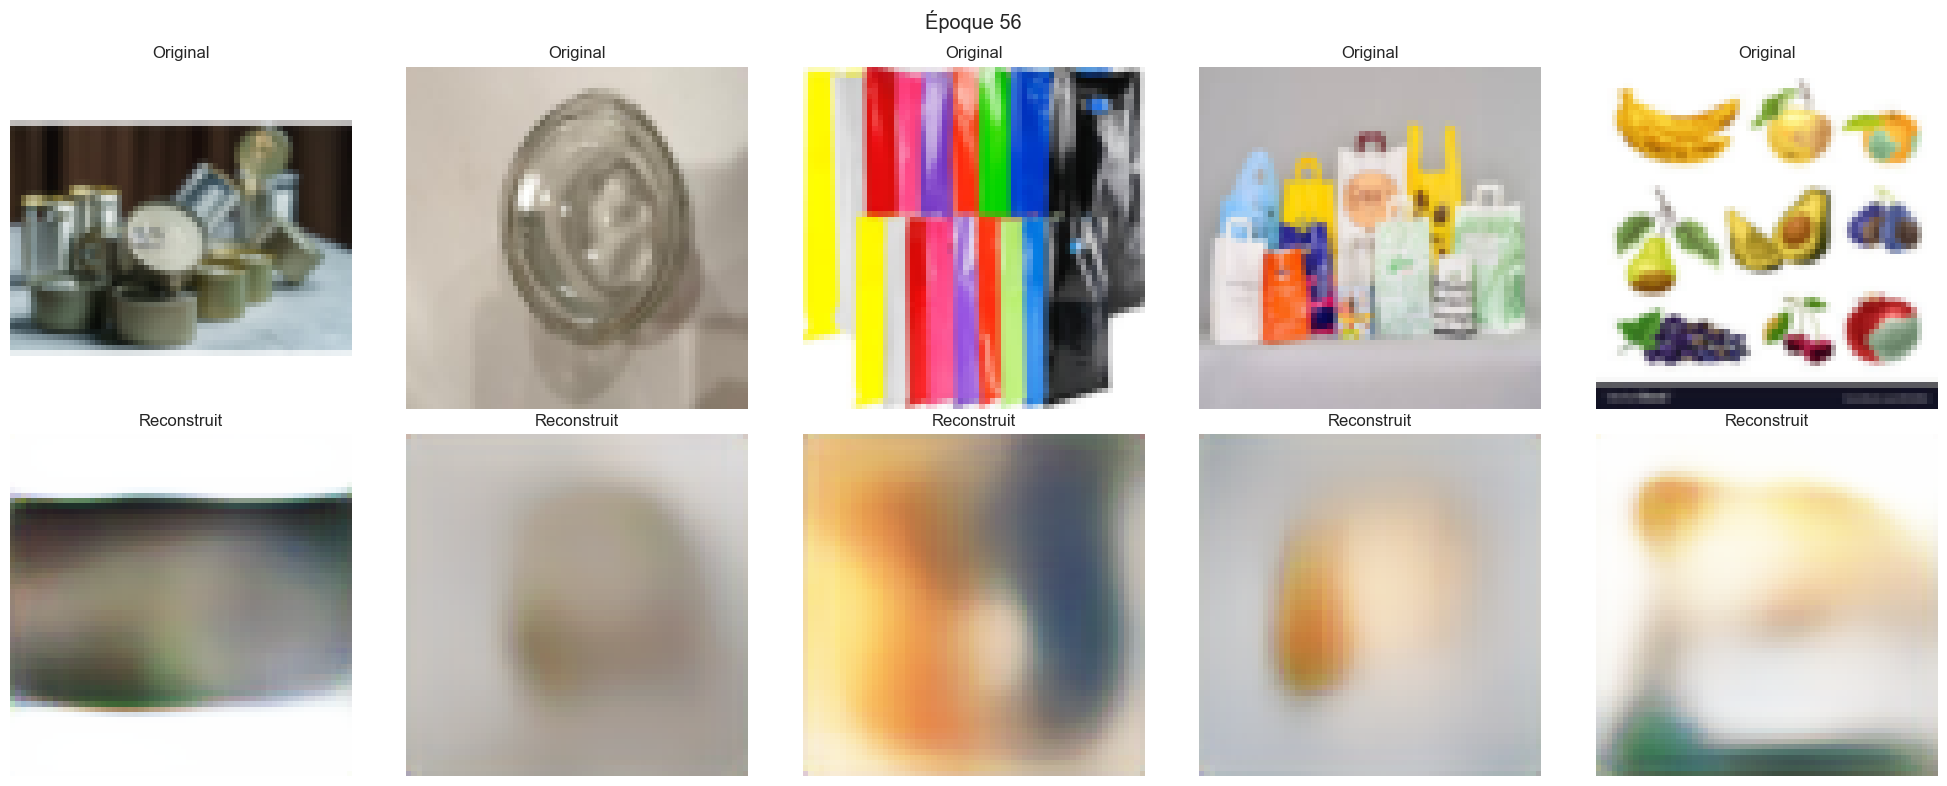

342/342 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - kl_loss: 4.7159 - loss: 2023.9048 - recon_loss: 2023.9048 - val_kl_loss: 6.0528 - val_loss: 2155.8870 - val_recon_loss: 2155.8870 - learning_rate: 1.0000e-04
Epoch 57/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl_loss: 4.7127 - loss: 2020.0509 - recon_loss: 2020.0509
Epoch 57: recon_loss improved from 2023.90479 to 2018.08923, saving model to model_dct_8.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


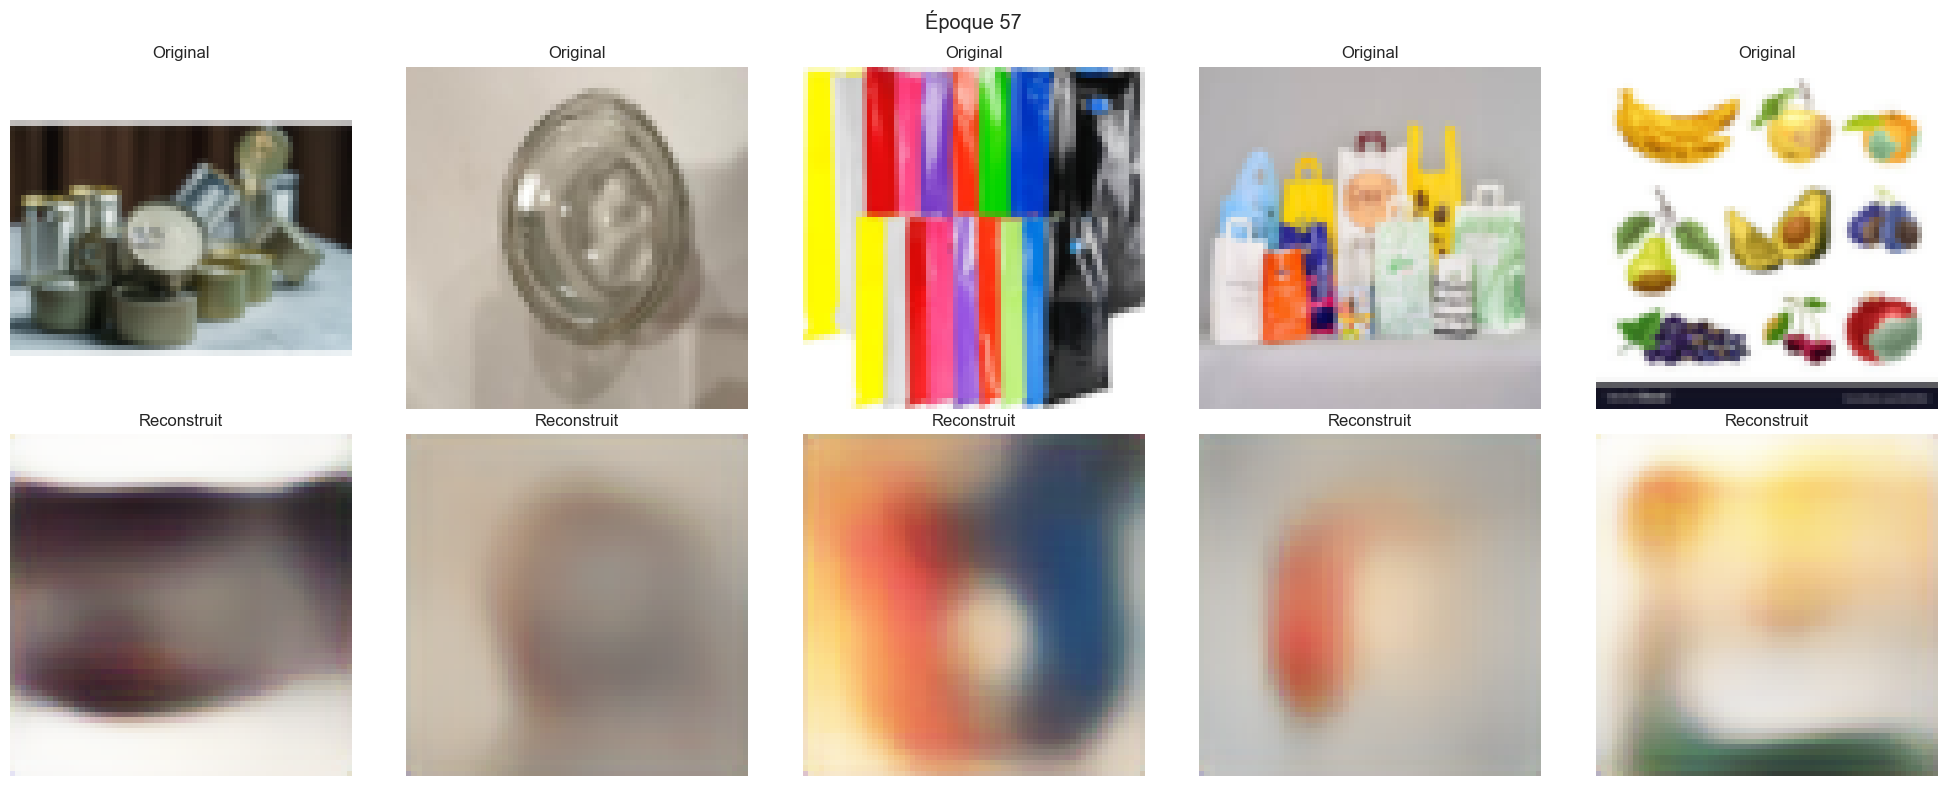

342/342 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - kl_loss: 4.7124 - loss: 2018.0892 - recon_loss: 2018.0892 - val_kl_loss: 6.0833 - val_loss: 2067.2134 - val_recon_loss: 2067.2134 - learning_rate: 1.0000e-04
Epoch 58/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl_loss: 4.7087 - loss: 2031.1743 - recon_loss: 2031.1743
Epoch 58: recon_loss did not improve from 2018.08923
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


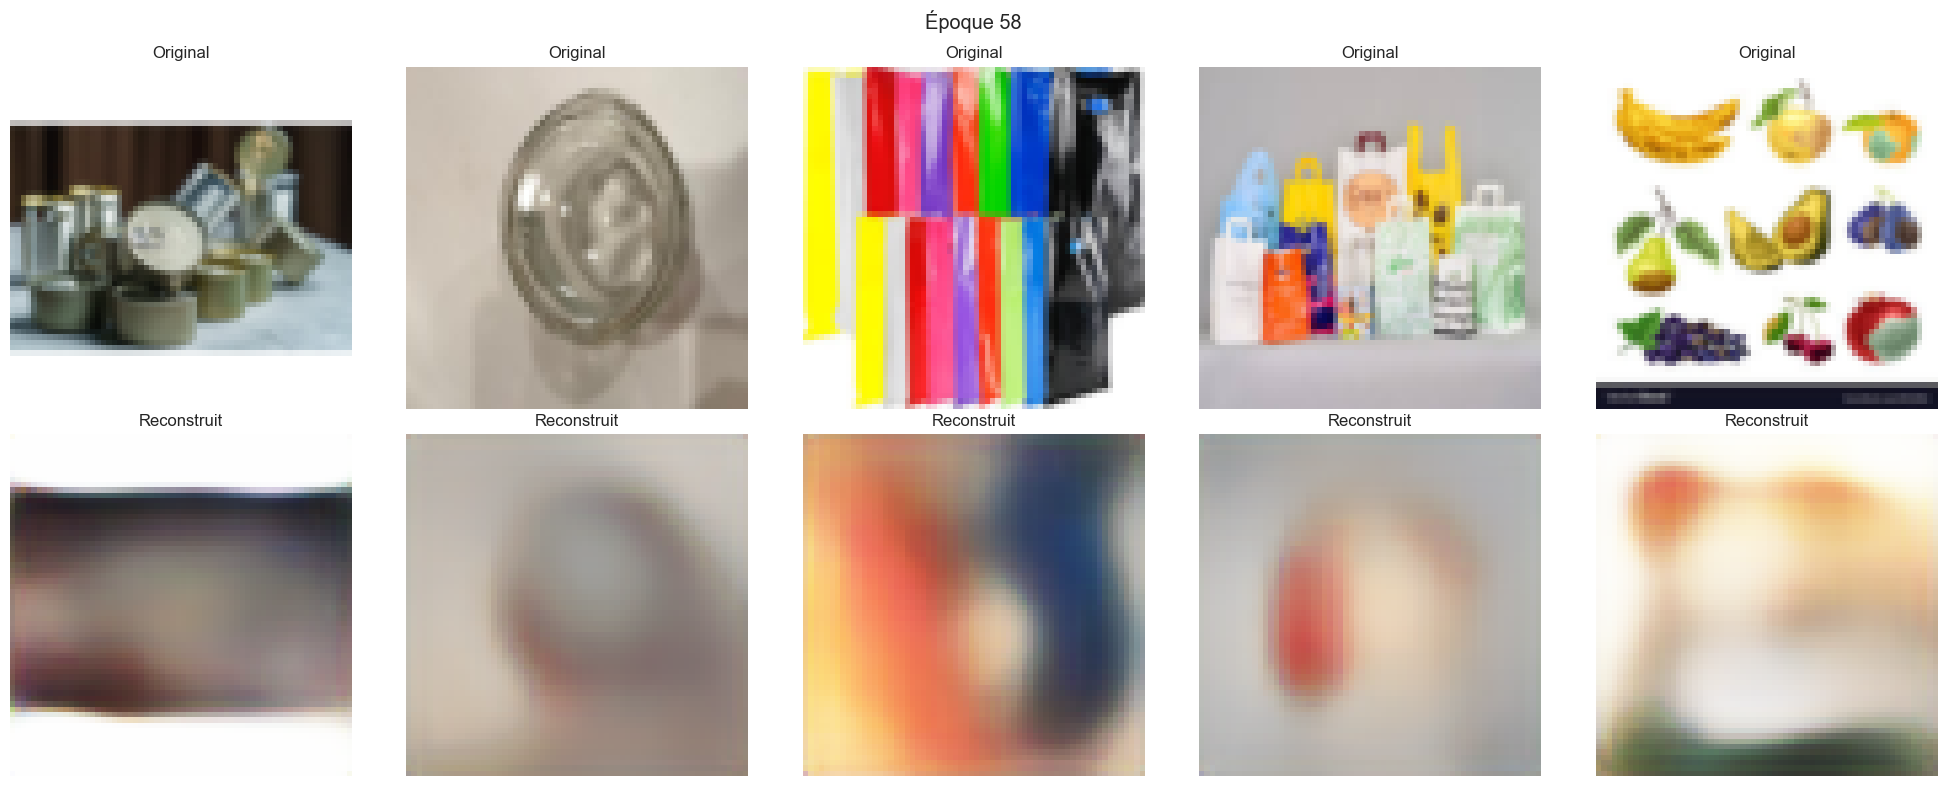

342/342 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - kl_loss: 4.7076 - loss: 2018.6464 - recon_loss: 2018.6464 - val_kl_loss: 6.3612 - val_loss: 2072.8755 - val_recon_loss: 2072.8755 - learning_rate: 1.0000e-04
Epoch 59/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl_loss: 4.7025 - loss: 2024.1604 - recon_loss: 2024.1604
Epoch 59: recon_loss did not improve from 2018.08923

Epoch 59: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


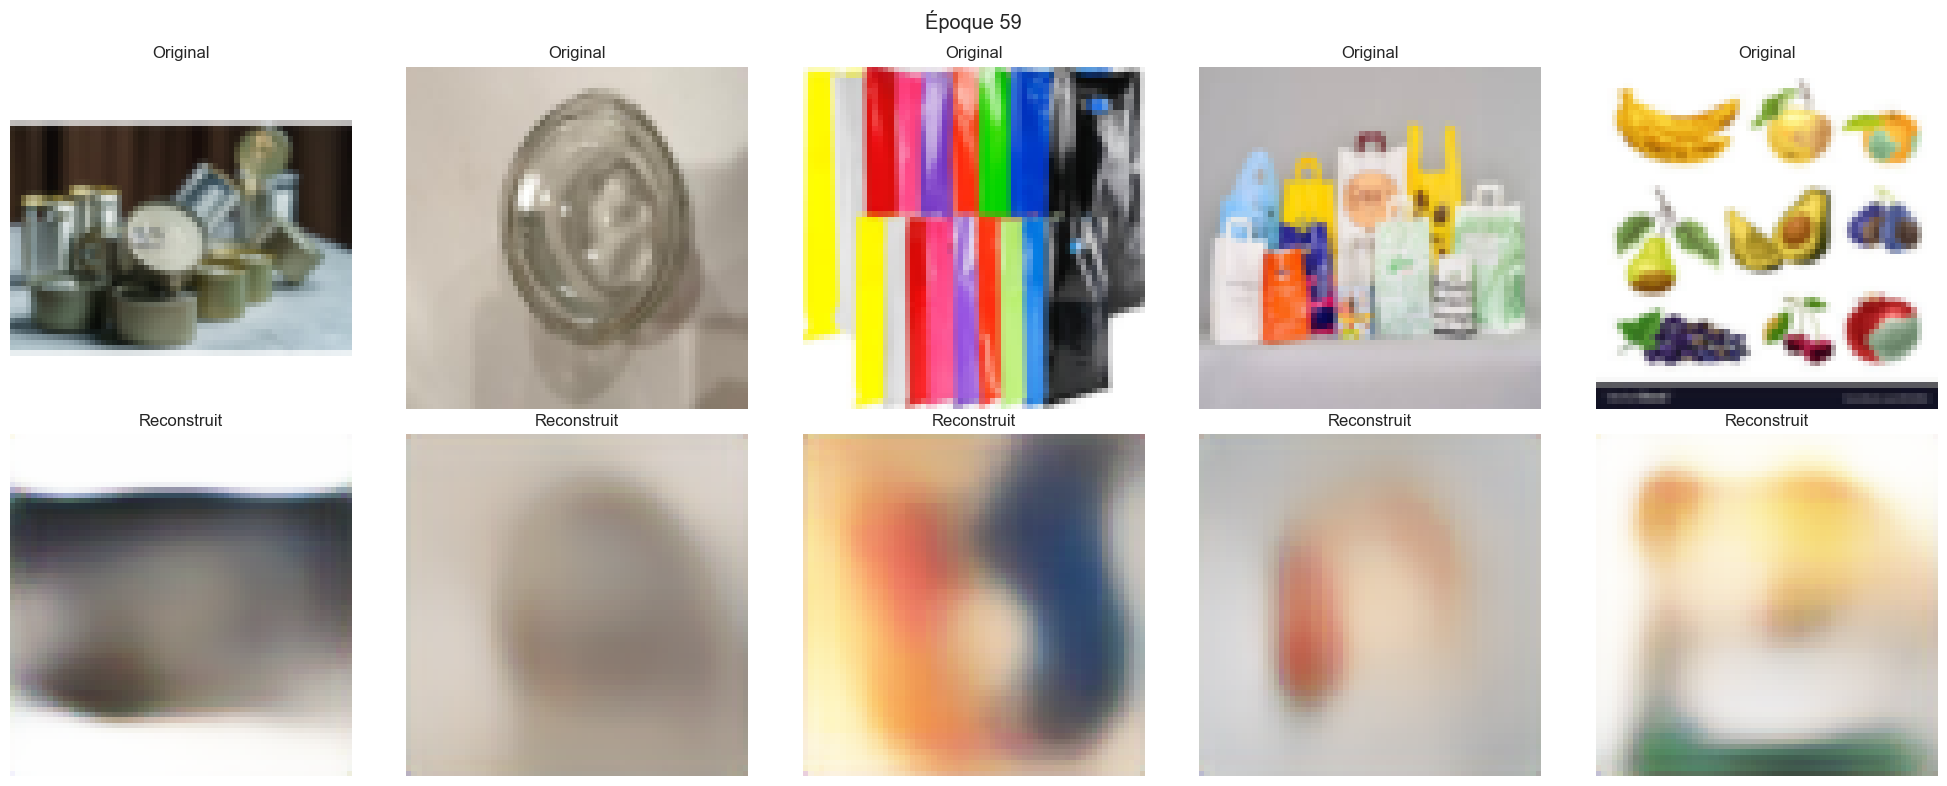

342/342 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - kl_loss: 4.7027 - loss: 2021.4537 - recon_loss: 2021.4537 - val_kl_loss: 6.0777 - val_loss: 2050.2759 - val_recon_loss: 2050.2759 - learning_rate: 1.0000e-04
Epoch 60/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 976ms/step - kl_loss: 4.6891 - loss: 2008.3313 - recon_loss: 2008.3313
Epoch 60: recon_loss improved from 2018.08923 to 2014.66797, saving model to model_dct_8.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


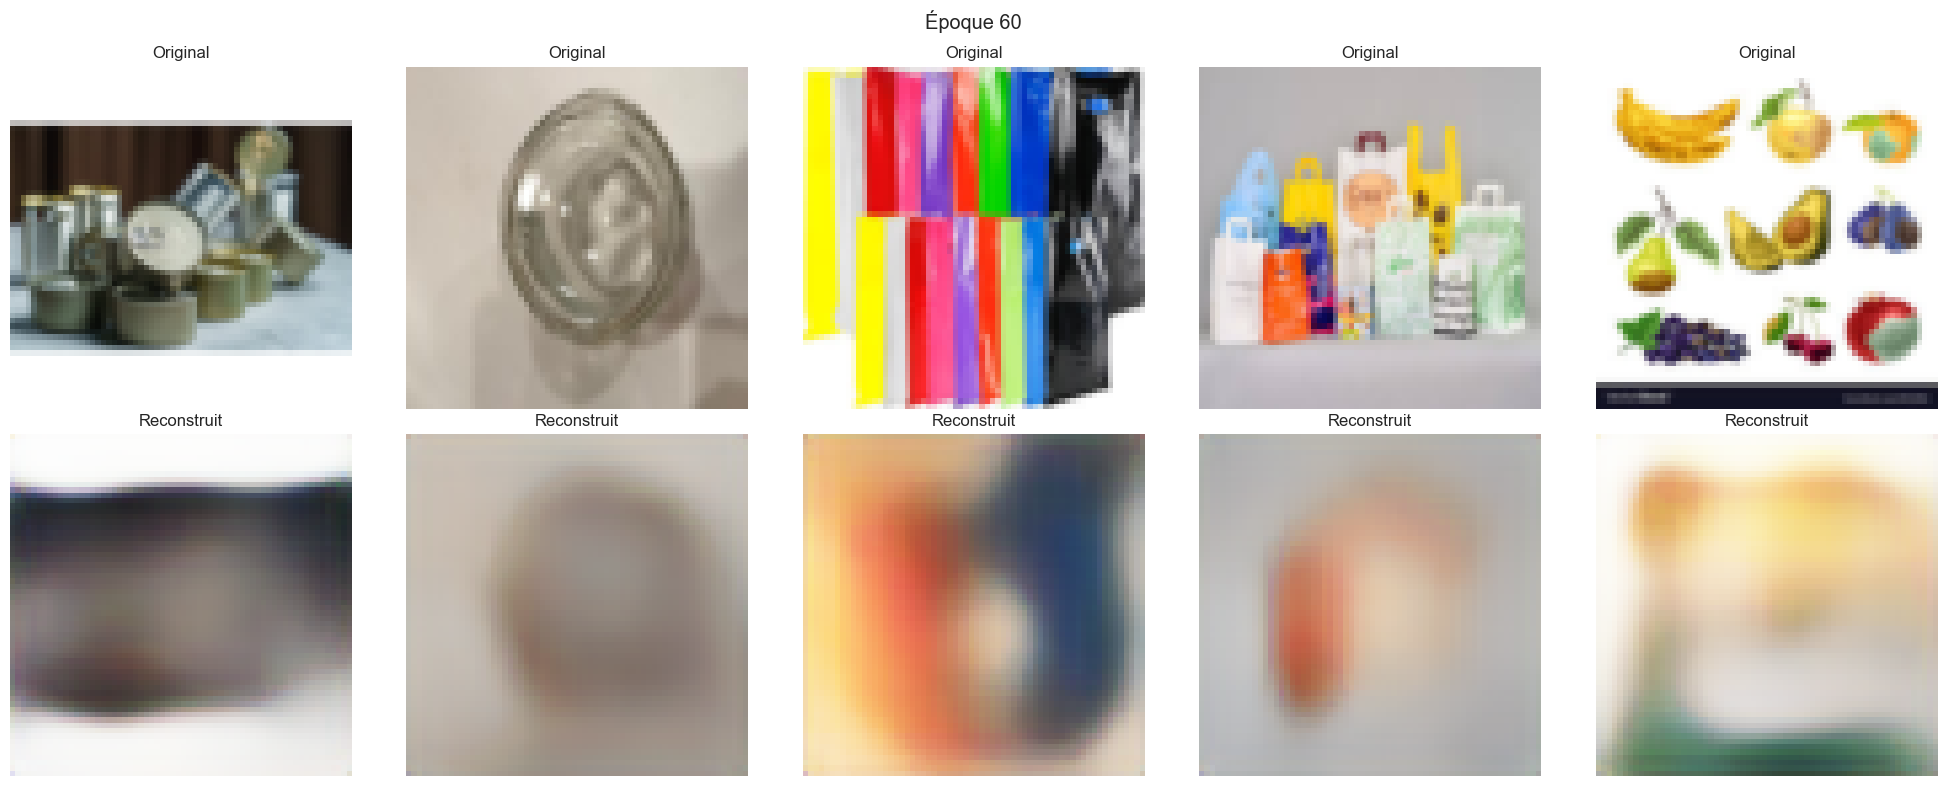

342/342 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - kl_loss: 4.6842 - loss: 2014.6680 - recon_loss: 2014.6680 - val_kl_loss: 5.9477 - val_loss: 2050.8870 - val_recon_loss: 2050.8870 - learning_rate: 5.0000e-05
Epoch 61/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - kl_loss: 4.6746 - loss: 2003.1888 - recon_loss: 2003.1888
Epoch 61: recon_loss improved from 2014.66797 to 2010.89856, saving model to model_dct_8.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


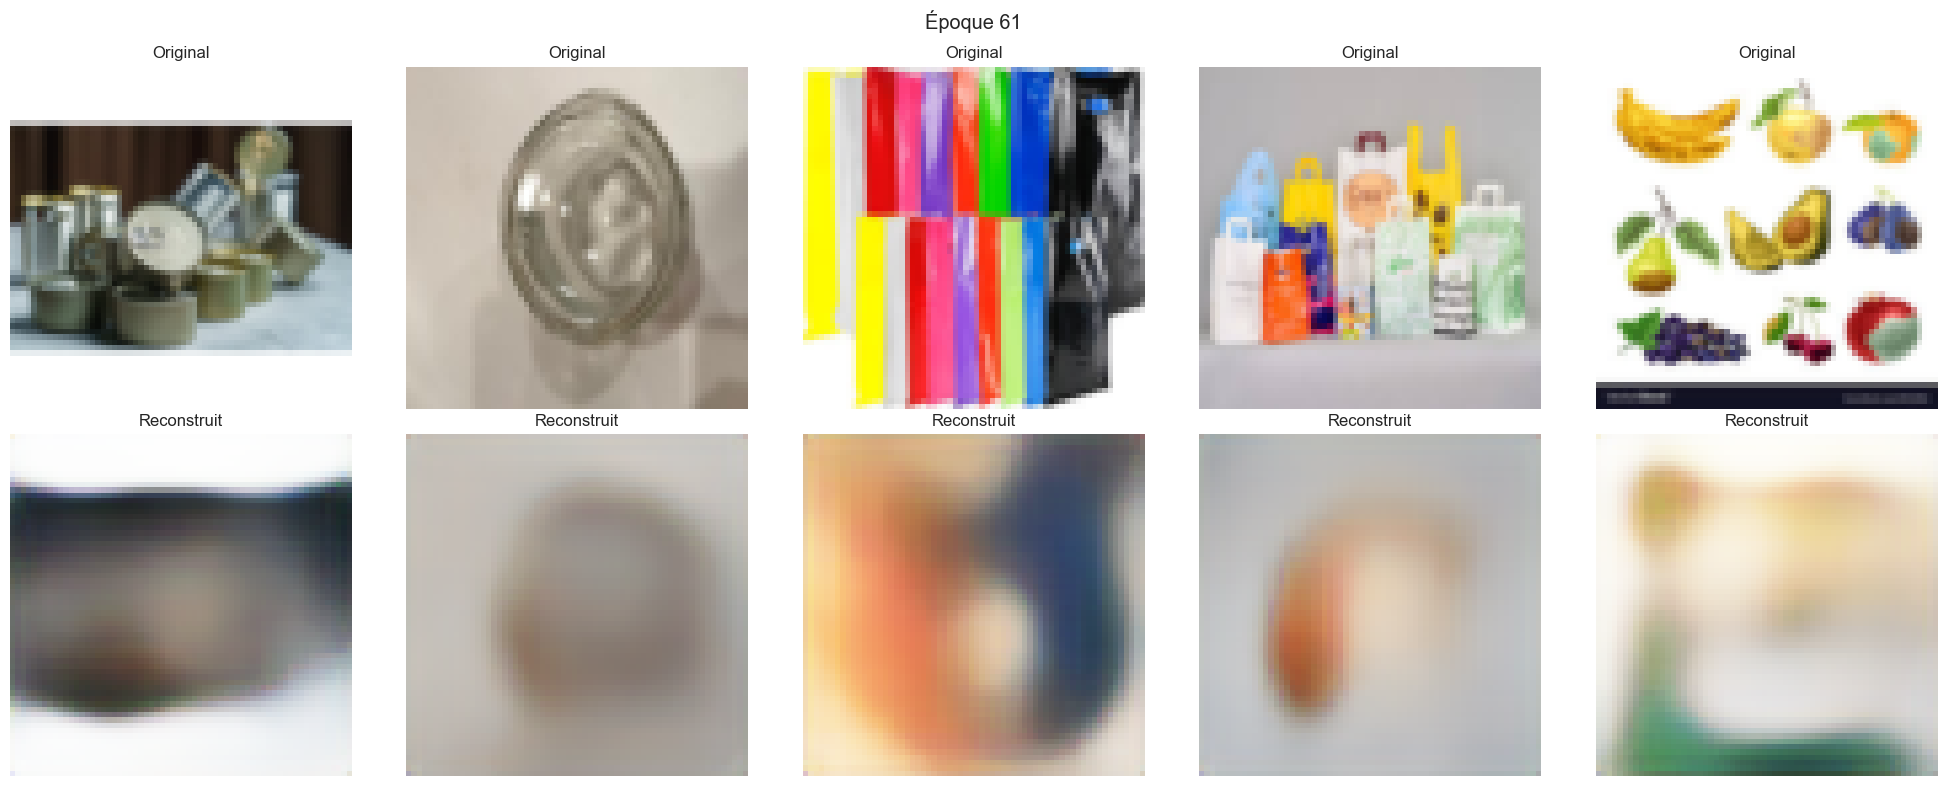

342/342 ━━━━━━━━━━━━━━━━━━━━ 2631s 8s/step - kl_loss: 4.6725 - loss: 2010.8986 - recon_loss: 2010.8986 - val_kl_loss: 5.8033 - val_loss: 2036.1310 - val_recon_loss: 2036.1310 - learning_rate: 5.0000e-05
Epoch 62/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - kl_loss: 4.6678 - loss: 1996.0906 - recon_loss: 1996.0906
Epoch 62: recon_loss improved from 2010.89856 to 1997.98975, saving model to model_dct_8.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


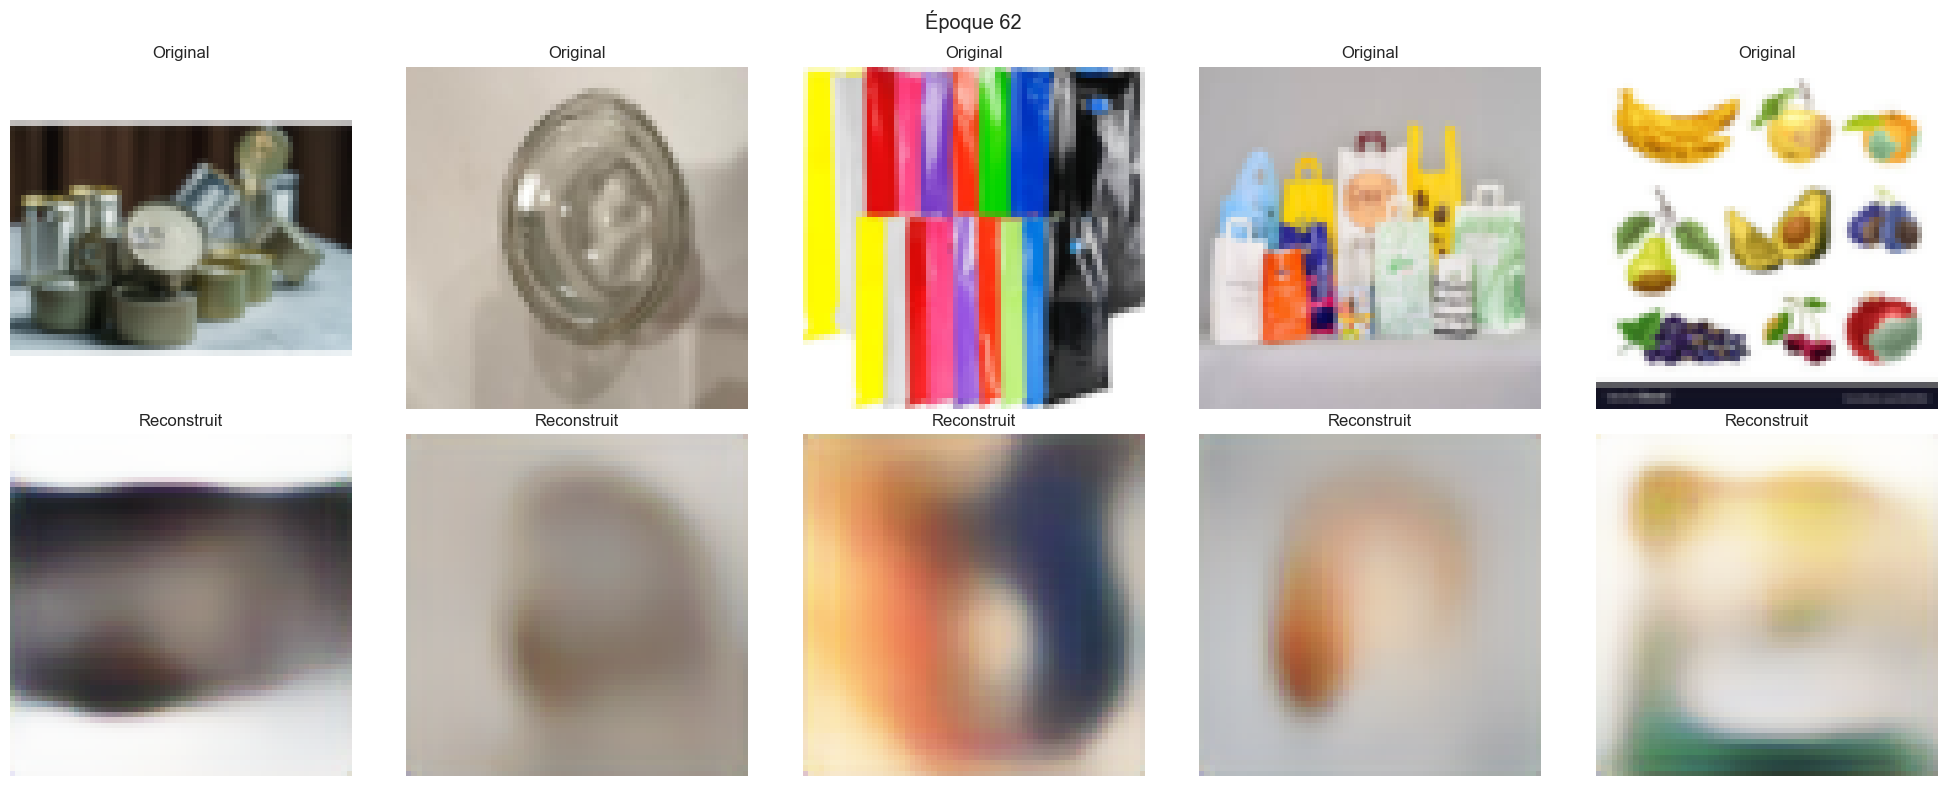

342/342 ━━━━━━━━━━━━━━━━━━━━ 982s 3s/step - kl_loss: 4.6674 - loss: 1997.9897 - recon_loss: 1997.9897 - val_kl_loss: 5.8903 - val_loss: 2039.3516 - val_recon_loss: 2039.3516 - learning_rate: 5.0000e-05
Epoch 63/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - kl_loss: 4.6644 - loss: 2005.9720 - recon_loss: 2005.9720
Epoch 63: recon_loss did not improve from 1997.98975
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


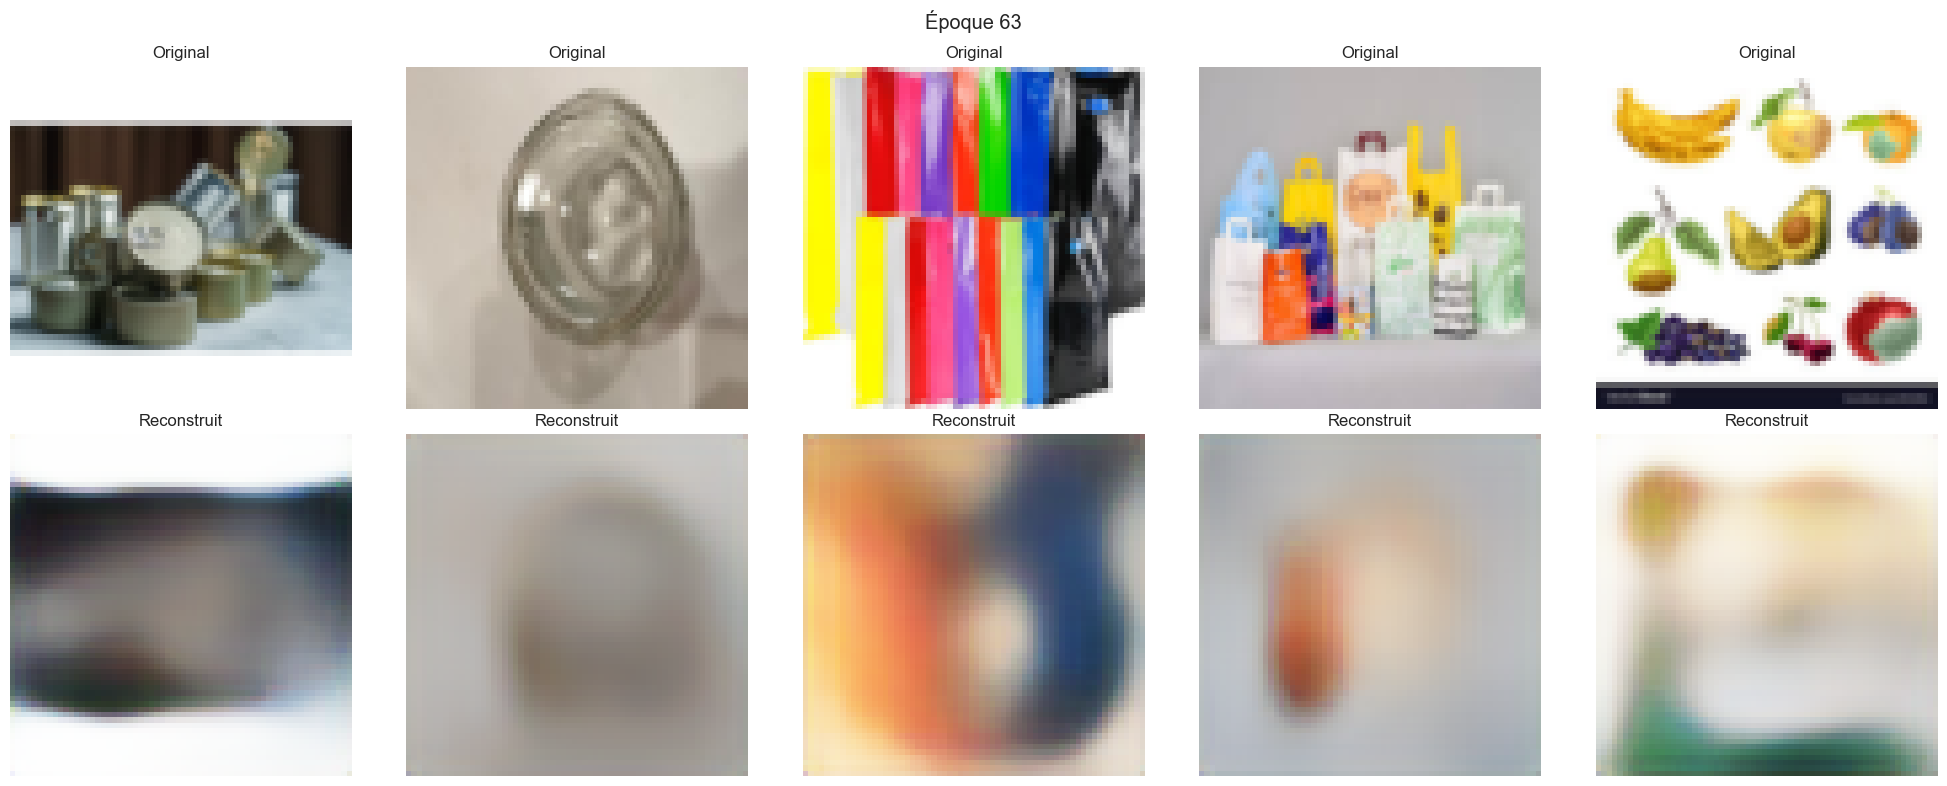

342/342 ━━━━━━━━━━━━━━━━━━━━ 913s 2s/step - kl_loss: 4.6624 - loss: 2011.8810 - recon_loss: 2011.8810 - val_kl_loss: 5.9148 - val_loss: 2038.3269 - val_recon_loss: 2038.3269 - learning_rate: 5.0000e-05
Epoch 64/100
260/342 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - kl_loss: 4.6593 - loss: 2030.5563 - recon_loss: 2030.5563

In [ ]:
# Compiler et entraîner le modèle avec visualisation
import time
start_time = time.time()
history = autoencoder.train(
    x_train = train_generator ,
    x_val = test_generator , 
    batch_size=16,
    epochs=start_epoch + 50,
     initial_epoch=start_epoch,
    x_vis=X_vis, 
    save_path="model_dct_8.keras"
)
end_time = time.time()
#elapsed = end_time - start_time
#hours, rem = divmod(rem, 3600)
#minutes, seconds = divmod(rem, 60)

#print(f"Temps d'entraînement : {int(days)}j {int(hours):02d}h {int(minutes):02d}m {int(seconds):02d}s")

autoencoder.save("model_dct_8.keras")
plot_result(history,name_fig="outo-loss",register=True)

In [ ]:
model1 = load_model("model_dct_6.keras", custom_objects={"ResidualVAE": ResidualVAE, "Sampling": Sampling})

In [ ]:
path = "C:/Users/hp/Pictures/Saved Pictures/im1.jpg"

In [ ]:
tf.keras.utils.plot_model(model1, show_shapes=True, show_layer_names=False, dpi=120)

In [ ]:
img,_ = outils.prepare_image(img_path=path,target_size=240)

In [31]:
img = X_vis[5:20]

In [45]:
img.shape

(5, 64, 64, 3)

In [32]:
encoded_imgs,g,z = autoencoder.encoder(img)

In [33]:
pred = autoencoder.decoder(z)

In [ ]:
autoencoder.save('model_dct_1.keras')

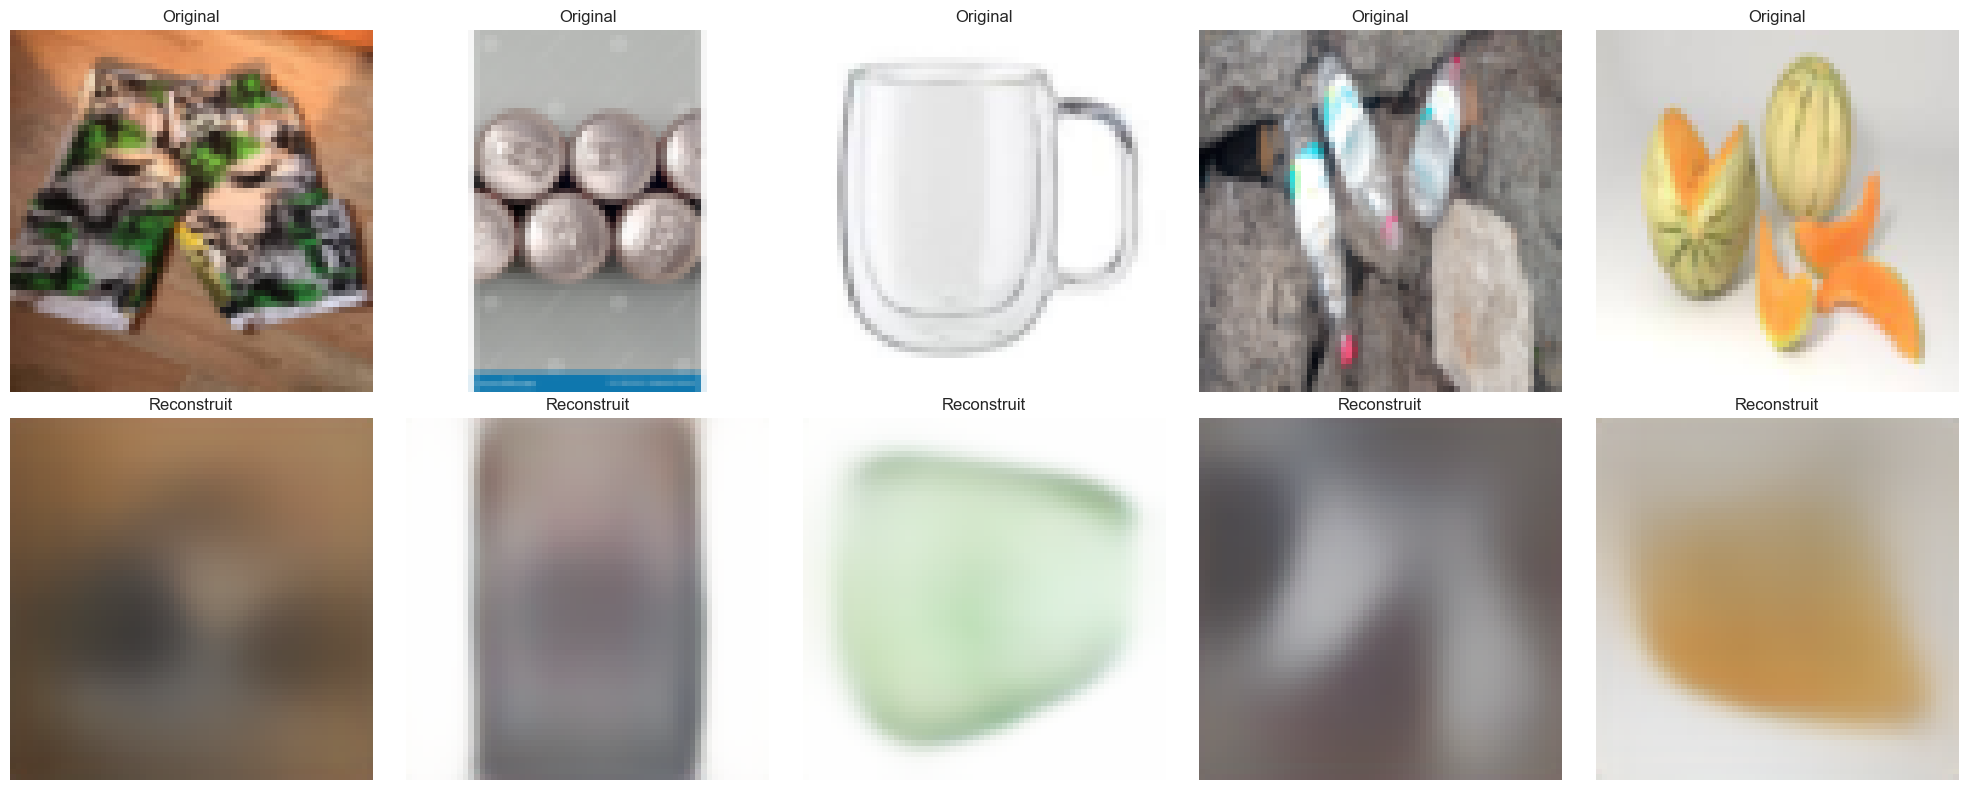

In [34]:
n = 5
plt.figure(figsize=(20, 8))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(np.clip(img[i], 0, 1))
    plt.axis("off")
    plt.title("Original")

    plt.subplot(2, n, n + i + 1)
    plt.imshow(np.clip(pred[i], 0, 1))
    plt.axis("off")
    plt.title("Reconstruit")
plt.savefig("test_auto.png")
plt.tight_layout()
plt.show()


In [35]:
df_anomalie = outils.Load_data.load_object("detect_anomalie.zip")

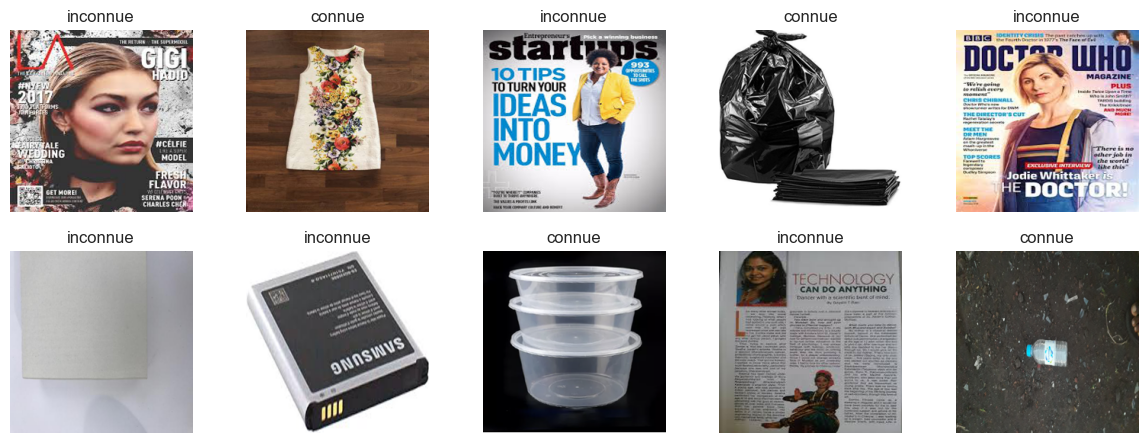

In [36]:
df_anomalie.plot(view_code=True)

In [37]:
df_anomalie.encodage()

In [50]:
df_anomalie.reshape(target_shape=input_shape, batch_size = 32)

Reshape en batch: 100%|██████████████████████████████████████████████████████████████| 125/125 [00:15<00:00,  8.23it/s]


In [51]:
(X_test_an, y_test_an), (_,_) = df_anomalie.create_data(test_size=0.0000000000001)

In [52]:
X_test_an = X_test_an.astype("float32") / 255

In [ ]:
np.unique(y_test_an,return_counts=True)

In [ ]:
(X_test_an, y_test_an), (_,_) = df_anomalie.create_data(test_size=0.0000000000001)

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import (
    confusion_matrix, roc_curve,
    precision_recall_curve, classification_report, roc_auc_score
)
import seaborn as sns
import pandas as pd

def detect_anomalies_complete_v2(autoencoder, x_data, y_true, thresholds, batch_size=32):
    """
    Détection d'anomalies complète avec visualisations et rapport détaillé.
    - Calcule les erreurs de reconstruction de manière itérative (optimisée pour faible RAM)
    - Évalue les performances selon plusieurs seuils
    - Trace les courbes des métriques + du nombre d’anomalies détectées
    - Affiche la matrice de confusion (en %) avec labels 'Normal' et 'Anormal'
    - Affiche un rapport global de classification
    """

    # ---------------------------
    # Étape 1 : Calcul des erreurs
    # ---------------------------
    print("Calcul des erreurs de reconstruction...")
    n = len(x_data)
    errors = []
    for i in tqdm(range(0, n, batch_size)):
        batch = x_data[i:i + batch_size]
       
        encoded_imgs,g,z = autoencoder.encoder(batch)
        recon = autoencoder.decoder(z)
        batch_errors = np.mean(np.square(batch - recon), axis=(1, 2, 3))
        errors.extend(batch_errors)
    errors = np.array(errors)

    # ---------------------------
    # Étape 2 : Histogramme des erreurs
    # ---------------------------
    plt.figure(figsize=(8, 5))
    plt.hist(errors[y_true == 0], bins=40, alpha=0.7, label="Normales")
    plt.hist(errors[y_true == 1], bins=40, alpha=0.7, label="Anomalies")
    plt.xlabel("Erreur de reconstruction")
    plt.ylabel("Fréquence")
    plt.title("Distribution des erreurs de reconstruction")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---------------------------
    # Étape 3 : Calcul des métriques pour chaque seuil
    # ---------------------------
    results = {}
    n_normals_detected, n_anomalies_detected = [], []

    for t in thresholds:
        y_pred = (errors > t).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
        prec = tp / (tp + fp + 1e-8)
        rec = tp / (tp + fn + 1e-8)
        f1 = 2 * prec * rec / (prec + rec + 1e-8)
        results[t] = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

        n_normals_detected.append((y_pred == 0).sum())
        n_anomalies_detected.append((y_pred == 1).sum())

    # Convertir en DataFrame pour analyse
    df_metrics = pd.DataFrame(results).T
    df_metrics["anomalies_detected"] = n_anomalies_detected
    df_metrics["normals_detected"] = n_normals_detected

    # ---------------------------
    # Étape 4 : Tracer les métriques et détections
    # ---------------------------
    fig, axes = plt.subplots(1, 2, figsize=(16,6))

    # (a) Nombre de détections
    axes[0].plot(thresholds, df_metrics["normals_detected"], label="Normales détectées")
    axes[0].plot(thresholds, df_metrics["anomalies_detected"], label="Anomalies détectées")
    axes[0].set_title("Évolution du nombre de détections")
    axes[0].set_xlabel("Seuil d'anomalie")
    axes[0].set_ylabel("Nombre d'échantillons")
    axes[0].legend()
    axes[0].grid(True)
    
    # (b) Évolution des métriques
    axes[1].plot(thresholds, df_metrics["accuracy"], label="Exactitude")
    axes[1].plot(thresholds, df_metrics["precision"], label="Précision")
    axes[1].plot(thresholds, df_metrics["recall"], label="Rappel")
    axes[1].plot(thresholds, df_metrics["f1"], label="F1-score")
    axes[1].set_title("Évolution des métriques selon le seuil")
    axes[1].set_xlabel("Seuil d'anomalie")
    axes[1].set_ylabel("Valeur métrique")
    axes[1].legend()
    axes[1].grid(True)

    plt.savefig("auto_metrix.png")
    plt.tight_layout()
    plt.show()

    # ---------------------------
    # Étape 5 : Courbes ROC et PR
    # ---------------------------
    fpr, tpr, _ = roc_curve(y_true, errors)
    precision, recall, _ = precision_recall_curve(y_true, errors)
    auc_score = roc_auc_score(y_true, errors)

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
    plt.xlabel("Taux de faux positifs (FPR)")
    plt.ylabel("Taux de vrais positifs (TPR)")
    plt.title("Courbe ROC")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision)
    plt.xlabel("Rappel")
    plt.ylabel("Précision")
    plt.title("Courbe Précision-Rappel")
    plt.grid(True)
    plt.show()

    # ---------------------------
    # Étape 6 : Seuil optimal + rapport complet
    # ---------------------------
    best_t = df_metrics["f1"].idxmax()
    print(f"\n Seuil optimal (F1 max) = {best_t:.5f}\n")
    print("Métriques associées :")
    print(df_metrics.loc[best_t].to_string(), "\n")

    y_pred_best = (errors > best_t).astype(int)
    
    # Matrice de confusion (avec labels et pourcentages)
    cm_best = confusion_matrix(y_true, y_pred_best)
    cm_percent = cm_best.astype('float') / cm_best.sum(axis=1)[:, np.newaxis]

    labels = ["Normal", "Anormal"]
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap="Blues", cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Prédiction")
    plt.ylabel("Vérité terrain")
    plt.title("Matrice de confusion - Seuil optimal")
    plt.savefig("matrix_auto.png")
    plt.show()

    print("Rapport de classification :")
    print(classification_report(y_true, y_pred_best, target_names=labels, digits=3))

    return errors, df_metrics, best_t


Calcul des erreurs de reconstruction...


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [04:11<00:00,  1.01s/it]


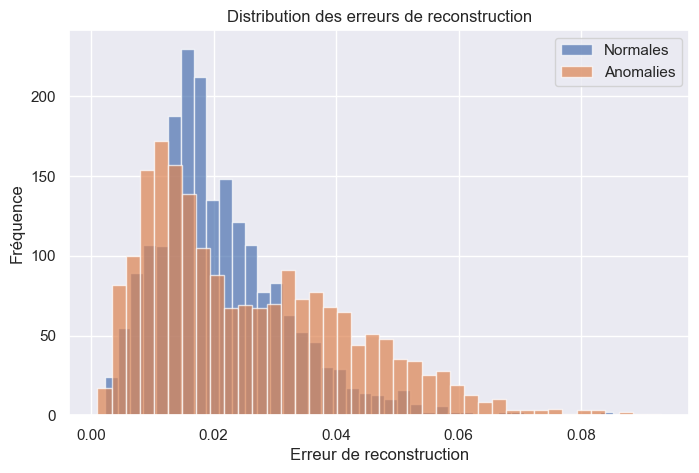

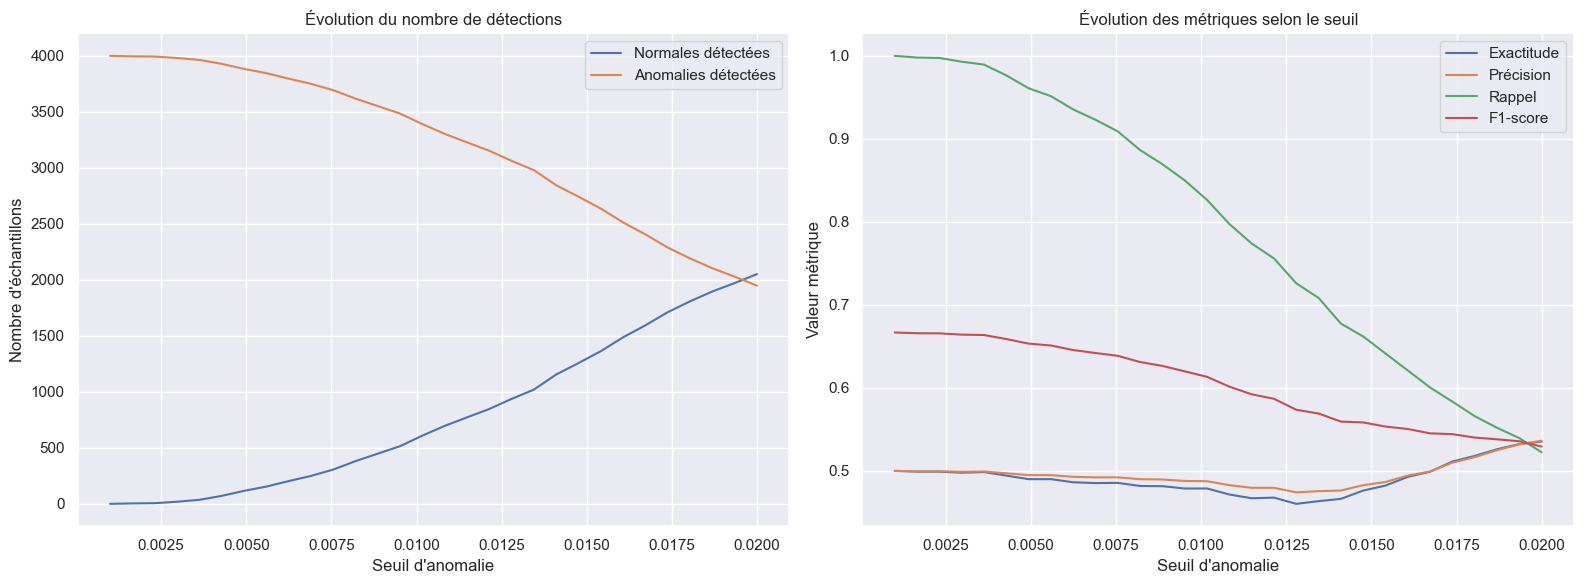

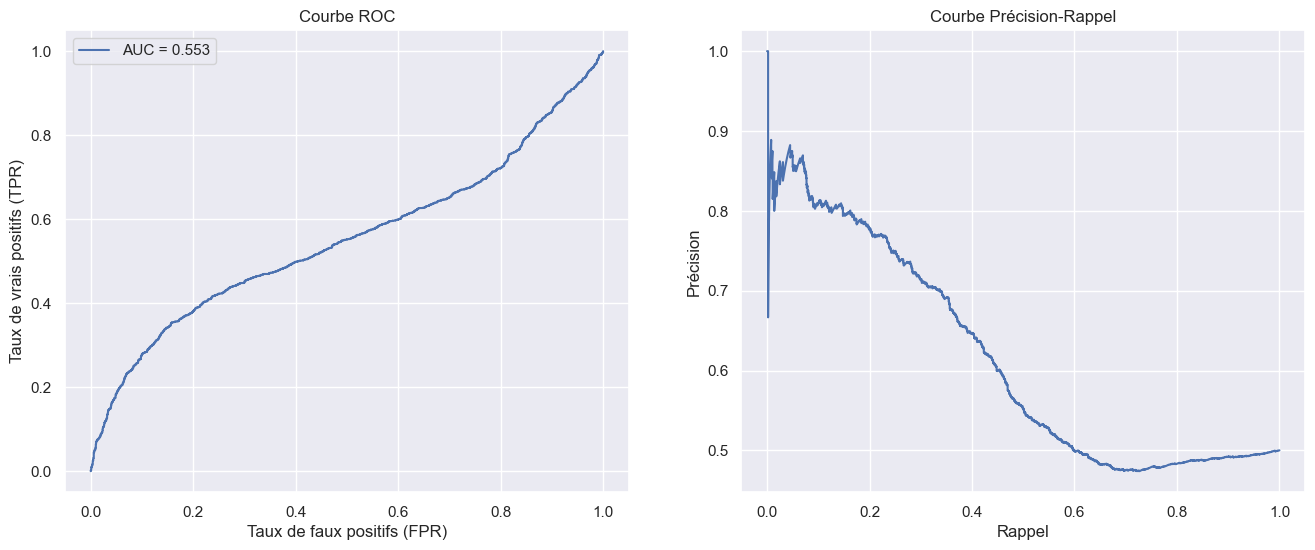


 Seuil optimal (F1 max) = 0.00100

Métriques associées :
accuracy                 0.500125
precision                0.500125
recall                   1.000000
f1                       0.666778
anomalies_detected    3999.000000
normals_detected         0.000000 



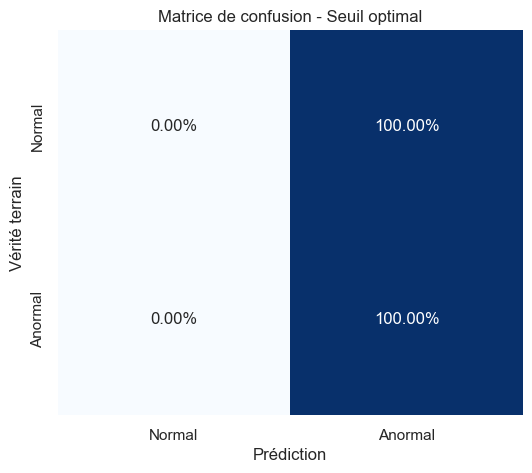

Rapport de classification :
              precision    recall  f1-score   support

      Normal      0.000     0.000     0.000      1999
     Anormal      0.500     1.000     0.667      2000

    accuracy                          0.500      3999
   macro avg      0.250     0.500     0.333      3999
weighted avg      0.250     0.500     0.333      3999



C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [55]:
thresholds = np.linspace(0.001, 0.02, 30)
errors, df_metrics, best_t = detect_anomalies_complete_v2(autoencoder, X_test_an, y_test_an, thresholds, batch_size=16)